In [1]:
import pandas as pd
import sys
sys.path.insert(1, '/Users/lifeifan/Desktop/ece1786/project/')
import string
import re
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import data_cleaning
from sklearn.model_selection import train_test_split
import numpy as np




from nltk.corpus import stopwords


df = pd.read_csv("../PolitiTrend/r_and_l.csv")


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lifeifan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lifeifan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
cleaned_data = data_cleaning.remove_stop_words(df,"text","cleaned_text")
cleaned_data = data_cleaning.remove_punctuations(cleaned_data,"cleaned_text","cleaned_text")
cleaned_data = data_cleaning.lemm_text(cleaned_data,"cleaned_text","cleaned_text")

In [ ]:
cleaned_data['cmp_code'] = cleaned_data['cmp_code'].replace({'laissez-faire': 0, 'regulationism': 1})
cleaned_data = cleaned_data.rename(columns={'cmp_code': 'label'})

In [4]:
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2LMHeadModel,
                          GPT2Tokenizer,
                          AdamW, 
                          TextDataset,
                          GPT2Config,
                          DataCollatorForLanguageModeling)

In [5]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [6]:
print(cleaned_data)

                                                   text  label  \
0     Twenty million people have gained health insur...      1   
1     They are working longer hours with less security.      1   
2                              Wages have barely budged      1   
3     while the cost of everything from childcare to...      1   
4     As working people struggle, the top one percen...      1   
...                                                 ...    ...   
1995  complete the devolution of Corporation Tax pow...      0   
1996  And we have pursued a bold, positive, pro-busi...      0   
1997       exempting smallest businesses from red tape,      0   
1998                              promoting free trade,      0   
1999  and pushing to extend the Single Market to new...      0   

                                           cleaned_text  
0     Twenty million people gained health insurance ...  
1                  They working longer hour le security  
2                                

In [7]:
import pandas as pd
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
import torch
# df_reset = df.reset_index(drop=True)
# x_train, x_val, y_train, y_val = train_test_split(df['text'], df['label'], test_size=0.2, shuffle=True)
# x_train = x_train.reset_index(drop=True)
# x_val = x_val.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)
# y_val = y_val.reset_index(drop=True)






In [8]:

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(cleaned_data, test_size=0.2, random_state=42)

# dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = str(self.dataframe.iloc[idx]['text'])
        label = int(self.dataframe.iloc[idx]['label'])

        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# GPT2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

configuration = GPT2Config()
model = GPT2ForSequenceClassification(configuration).from_pretrained("gpt2",num_labels=2)
model.config.pad_token_id = model.config.eos_token_id


train_dataset = CustomDataset(train_df, tokenizer)
val_dataset = CustomDataset(val_df, tokenizer)

# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [9]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 4

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        logits = outputs.logits
        _, predicted_labels = torch.max(logits, 1)
        train_acc += (predicted_labels == labels).sum().item()

        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(train_loader)
    train_acc = train_acc/len(train_df)
    train_loss_list.append(train_loss)  
    train_acc_list.append(train_acc)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss}, accuracy: {train_acc}')

    # Validation loop
    model.eval()
    val_loss = 0
    val_acc = 0
    total_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            logits = outputs.logits
            _, predicted_labels = torch.max(logits, 1)
            val_acc += (predicted_labels == labels).sum().item()

    val_loss /= len(val_loader)    
    val_loss_list.append(val_loss)            
    val_acc /= len(val_df)                    
    val_acc_list.append(val_acc)  


    print(f'Validation Loss: {val_loss}, Accuracy: {val_acc}')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4, Loss: 0.577736425511539, accuracy: 0.70125
Validation Loss: 0.5313522825017571, Accuracy: 0.7375
Epoch 2/4, Loss: 0.371872308482416, accuracy: 0.833125
Validation Loss: 0.40400764882564544, Accuracy: 0.8175
Epoch 3/4, Loss: 0.19399635827212477, accuracy: 0.930625
Validation Loss: 0.463707391169155, Accuracy: 0.8275
Epoch 4/4, Loss: 0.08696834067464806, accuracy: 0.969375
Validation Loss: 0.44652091565076263, Accuracy: 0.835


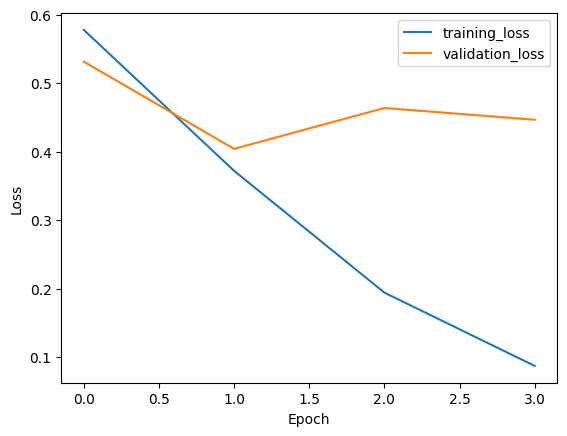

In [10]:

plt.plot(train_loss_list, label='training_loss')
plt.plot(val_loss_list, label='validation_loss')

plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

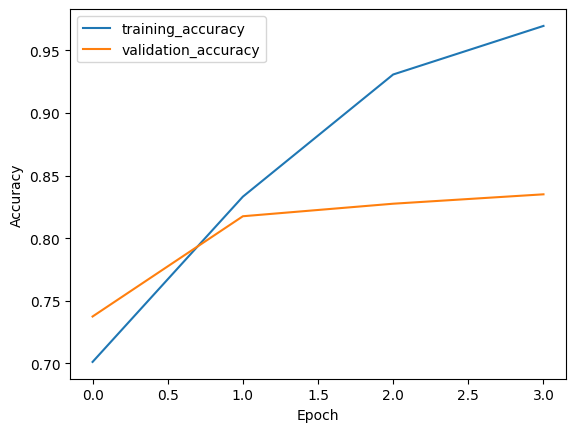

In [11]:
plt.plot(train_acc_list, label='training_accuracy')
plt.plot(val_acc_list, label='validation_accuracy')

plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [13]:
model.save_pretrained('/Users/lifeifan/Desktop/ece1786/project/model_parameters/gpt2(r_and_l)')

In [14]:

model_path = '/Users/lifeifan/Desktop/ece1786/project/model_parameters/gpt2(r_and_l)'
loaded_model = GPT2ForSequenceClassification.from_pretrained(model_path)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')



In [18]:

text = "To return the States to their proper role of regulating  local  insurance  markets  and  caring  for  the needy,  we  propose  to  block  grant  Medicaid  and  other payments  to  the  States;"

inputs = tokenizer(text, return_tensors='pt')

outputs = loaded_model(**inputs)


logits = outputs.logits
predicted_labels = torch.argmax(logits, dim=1)


label_mapping = {0: 'liberalism', 1: 'regulationism'}
predicted_class = label_mapping[predicted_labels.item()]

print(f'Predicted class: {predicted_class}')
print(torch.softmax(logits,dim=1))

Predicted class: liberalism
tensor([[0.9986, 0.0014]], grad_fn=<SoftmaxBackward0>)


In [12]:
# def process_data(x,y):
#     processed_data = []
#     for i in range(len(x)):
#         text = tokenizer(x[i], padding="max_length", truncation=True, return_tensors="pt")
#         labels = y[i]
#         processed_data.append({"input_ids": text["input_ids"], "attention_mask": text["attention_mask"], "labels": labels})
#     return processed_data

# train_data = process_data(x_train,y_train)

# valid_data = process_data(x_val,y_val)

# configuration = GPT2Config()
# model = GPT2ForSequenceClassification(configuration).from_pretrained("gpt2",num_labels=2)
# model.config.pad_token_id = model.config.eos_token_id


# train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
# valid_dataloader = DataLoader(valid_data, batch_size=32)



Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
print(model)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)


In [16]:
# from transformers import AdamW
# import torch.nn.functional as F

# train_loss_list = []
# train_acc_list = []
# val_loss_list = []
# val_acc_list = []
# learning_rate = 2e-5
# optimizer = AdamW(model.parameters(), lr=learning_rate)
# epochs = 10
# for epoch in range(epochs):
#     train_acc = 0
#     train_loss = 0
#     for batch in train_dataloader:
#         inputs = batch["input_ids"].squeeze()
#         attention_mask = batch["attention_mask"].squeeze()
#         labels = batch["labels"]
#         # print(inputs)
#         # print(attention_mask)
#         # print(labels)

#         # Forward pass
#         outputs = model(inputs, attention_mask=attention_mask, labels=labels)  
#         # print(outputs)
#         # Compute the loss
#         loss = outputs.loss
#         logit = F.softmax(outputs.logits, dim=1)
#         train_pred = torch.round(logit).long()
#         max_indices = torch.argmax(train_pred, dim=1)
#         train_pred = torch.where(max_indices == 0, torch.tensor([0.0]), torch.tensor([1.0]))
#         train_pred = train_pred.int()
#         for i in range(len(labels)):
#             if train_pred[i] == labels[i]:
#                 train_acc += 1
#         train_loss += loss.item()
#         # Backpropagation and optimization
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#         print(1)
                
#     train_loss /= len(train_dataloader)
#     train_acc = train_acc/len(train_data)
#     train_loss_list.append(train_loss)  
#     train_acc_list.append(train_acc)
#     print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

#     val_loss = 0
#     val_acc = 0
#     for batch in valid_dataloader: 
#         inputs = batch["input_ids"].squeeze()
#         attention_mask = batch["attention_mask"].squeeze()
#         labels = batch["labels"]

#         outputs = model(inputs, attention_mask=attention_mask, labels=labels)  
#         logit = F.softmax(outputs.logits, dim=1)
#         val_pred = torch.round(logit).long()
#         max_indices = torch.argmax(val_pred, dim=1)
#         val_pred = torch.where(max_indices == 0, torch.tensor([0.0]), torch.tensor([1.0]))
#         val_pred = val_pred.int()
#         for i in range(len(labels)):
#             if val_pred[i] == labels[i]:
#                 val_acc += 1
#         val_loss += loss.item()

    
#     val_loss /= len(valid_dataloader)    
#     val_loss_list.append(val_loss)            
#     val_acc /= len(valid_data)                    
#     val_acc_list.append(val_acc)  
#     print((f'Epoch {epoch + 1}/{epochs}, validation loss: {val_loss:.4f}, val_acc: {val_acc:.4f}')) 



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


KeyboardInterrupt: 